In [5]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed

In [6]:
IC_resolution = 0.5
dt = 0.0025
DT = 0.1
freq = 1
geodesic = False
e = 0
n_clusters=0
K=1000
k_exp=20

formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

special_name = "beaufort_zoom_lead_febmars"
filename = f"OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_90Rx_{special_name}.nc"

Fmap_params = f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"

Cluster_params = f"geodesic_{geodesic}_nclusters{n_clusters}_e{formatted_e}"

directory = f"/cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/{special_name}/"
file_path = f"{directory}Fmap/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path


geo_file_path = f"{directory}{filename}"


In [7]:
if not os.path.exists(results_directory):
    os.makedirs(results_directory)


Cluster_params = (
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e:.2f}"
)

W_params = (
    f"geodesic_{geodesic}"
)



# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")


from from_similarity_to_eigen import from_similarity_to_eigen

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import gif_clusters_landmask


# In[69]:


print("Reading data")
#Read input data
Fmap_path = file_path+'/Fmap_matrix.npy'
time_path = file_path+'/advection_time.npy'
W_path = file_path+'/W_matrix_'+W_params+'.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
W_vec = np.load(W_path)

dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
siu = dataset.variables['vlon'][0,:,:]
land_mask=siu[:,:].mask

# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]

dataset.close()


Reading data


In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.interpolate import griddata
def ini_final_clusters_landmask_contour(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol):
    positions_ini = Fmap[0, :, :]
    positions_end = Fmap[-1, :, :]
    
    ymax = Fmap[:, 1, :].max()
    ymin = Fmap[:, 1, :].min()
    xmax = Fmap[:, 0, :].max()
    xmin = Fmap[:, 0, :].min()
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Create a grid for contour plotting
    grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    
    # Interpolate the labels onto the grid
    grid_labels_ini = griddata((positions_ini[0, :], positions_ini[1, :]), labels, (grid_x, grid_y), method='nearest')
    grid_labels_end = griddata((positions_end[0, :], positions_end[1, :]), labels, (grid_x, grid_y), method='nearest')
    # First subplot
    #scatter1 = axes[0].scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)
    #scatter_ini = axes[0].scatter(positions_ini[0, :], positions_ini[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, edgecolor='k', linewidth=0.5)
    contour1 = axes[0].contour(grid_x, grid_y, grid_labels_ini, levels=np.arange(n_clusters+1)-0.5, colors='k', linewidths=0.5)
    # Add contour plot to the first subplot
    contour_land = axes[0].contour(x, y, mask_interpol, levels=10, cmap='viridis', alpha=0.5)
    axes[0].set_xlabel("X Position")
    axes[0].set_ylabel("Y Position")
    axes[0].set_title("Initial distribution of the clusters")
    axes[0].set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    axes[0].set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    axes[0].set_aspect('equal', 'box')
    # Add contour lines to show label changes
    
    # Second subplot
    #scatter2 = axes[1].scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)
    #scatter_end = axes[1].scatter(positions_end[0, :], positions_end[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, edgecolor='k', linewidth=0.5)
    contour2 = axes[1].contour(grid_x, grid_y, grid_labels_end, levels=np.arange(n_clusters+1)-0.5, colors='k', linewidths=0.5)
    axes[1].set_xlabel("X Position")
    axes[1].set_title("Final distribution of the clusters")
    axes[1].set_aspect('equal', 'box')
    axes[1].set_xlim(xmin-0.08*(xmax-xmin), xmax+0.08*(xmax-xmin)) 
    axes[1].set_ylim(ymin-0.08*(xmax-xmin), ymax+0.08*(ymax-ymin))  
    # Add contour lines to show label changes
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],
                          markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    axes[1].legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))
    # Main title
    plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()
   

Computing the eigenvalues
The percentage of spercified elements is 0.2514330717151654
[]
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 4


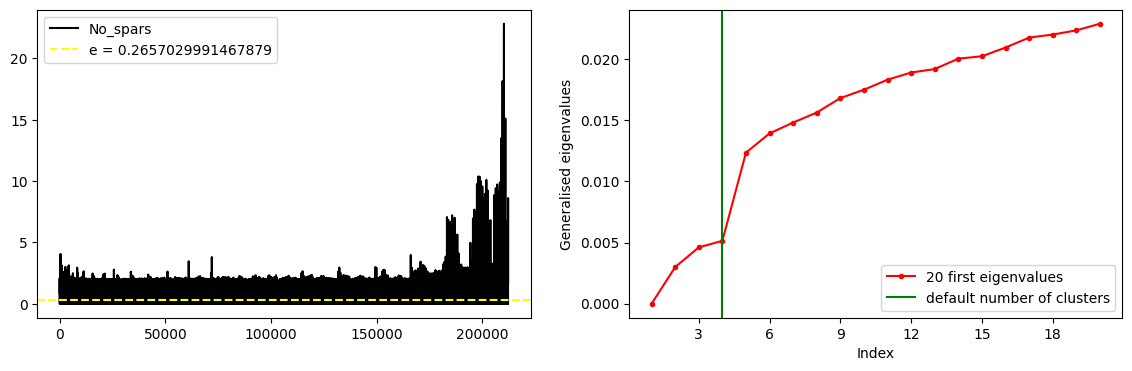

In [33]:
print("Computing the eigenvalues")
if e==0:
    e = np.std(W_vec[W_vec<999])


fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(W_vec[W_vec<999], color = 'black', label="No_spars")
axes[0].axhline(y=e, color='yellow', linestyle='--', label=f'e = {e}')
axes[0].legend()

l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen(Fmap, W_vec, e, K, k_exp)

lx = np.arange(1, len(l) + 1)
axes[1].plot(lx,l,marker='.',color='red',label=str(k_exp)+" first eigenvalues")
axes[1].axvline(x=n_clusters_def, color="green",label="default number of clusters")
axes[1].legend()
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Generalised eigenvalues")
plt.show
plt.savefig(results_directory+"eigenvalues_"+Cluster_params+".png")


def kmeans(n_clusters, l_vect):
    print("Applying k-means to define the clusters")
    if n_clusters==0:
        n_clusters = n_clusters_def  

    l_vect_cut = l_vect[:,0:n_clusters]
    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect_cut)
    labels = kmeans.labels_

    np.save(results_directory+'/Clusters_labels_'+Cluster_params+'.npy', labels)
    np.save(results_directory+'/Fmap_'+Cluster_params+'.npy', Fmap)


    print("Plotting the clusters")
    #ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
    ini_final_clusters_landmask_contour(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
    if n_clusters==4:
        gif_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_4.gif", e, longitude, latitude, land_mask,10)
    if n_clusters==10:
        gif_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_4.gif", e, longitude, latitude, land_mask,10)
    return 0



Applying k-means to define the clusters
Plotting the clusters


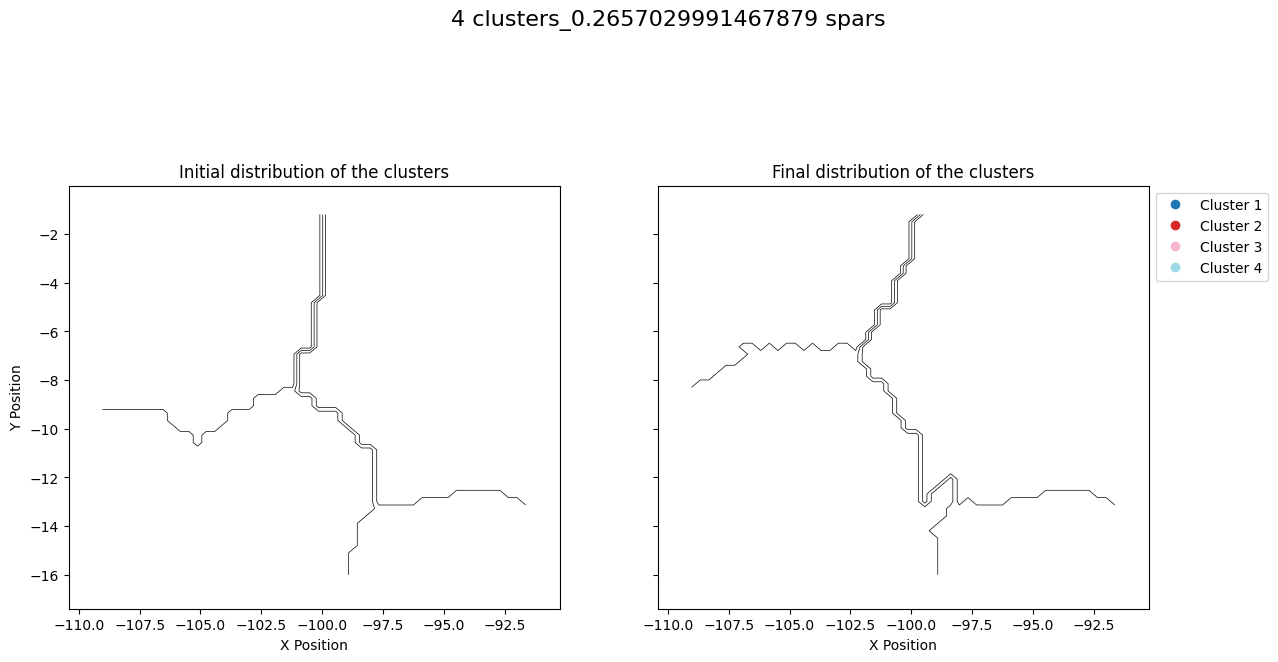

Animation saved to /cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/beaufort_zoom_lead_febmars/Fmap/ic0.5_dt0.0025_DT0.1000/clustersgeodesic_False_nclusters0_e0.00_4.gif


In [34]:
for i in range (4,5):
    kmeans(i,l_vect)



In [35]:
def ini_final_clusters_landmask(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol):
    positions_ini=Fmap[0,:,:]
    positions_end=Fmap[-1,:,:]
    
    ymax = Fmap[:,1,:].max()
    ymin = Fmap[:,1,:].min()
    xmax = Fmap[:,0,:].max()
    xmin = Fmap[:,0,:].min()

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend

    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972),
            (1, 1, 1)]  # Grey (RGB for white)  # Light blue (RGB for light sky blue)
    # Create the colormap
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)

    # First subplot
    scatter1 = axes[0].scatter(x.ravel(), y.ravel(),marker='.',s=0.1,c=mask_interpol, cmap=colors_mask)
    axes[0].scatter(positions_ini[0,:], positions_ini[1,:], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1)
    axes[0].set_xlabel("X Position")
    axes[0].set_ylabel("Y Position")
    axes[0].set_title("Initial distribution of the clusters")
    axes[0].set_xlim(xmin-0.05*(xmax-xmin),xmax+0.05*(xmax-xmin)) 
    axes[0].set_ylim(ymin-0.05*(xmax-xmin),ymax+0.05*(ymax-ymin))  
    axes[0].set_aspect('equal', 'box')
    
    # Second subplot
    scatter2 = axes[1].scatter(x.ravel(), y.ravel(),marker='.',s=0.1,c=mask_interpol, cmap=colors_mask)
    axes[1].scatter(positions_end[0,:], positions_end[1,:], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1)
    axes[1].set_xlabel("X Position")
    axes[1].set_title("Final distribution of the clusters")
    axes[1].set_aspect('equal', 'box')
    axes[1].set_xlim(xmin-0.08*(xmax-xmin),xmax+0.08*(xmax-xmin)) 
    axes[1].set_ylim(ymin-0.08*(xmax-xmin),ymax+0.08*(ymax-ymin))  
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],
                            markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    axes[1].legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))

    # Main title
    plt.suptitle(f"{n_clusters}clusters_{e}spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")